The skewness for the MCS travel speed dataset is -4.572
Parameters for normal distribution: (50.146, 14.052)
Parameters for exponential distribution: (-179.299, 229.445)
Parameters for beta distribution: (8927054.119, 8.927, -38035273.455, 38035361.667)
Original sample size: 1000
Filtered sample size: 998


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


New parameters for normal distribution: (50.426, 11.936)
New parameters for exponential distribution: (15.301, 35.125)
New parameters for beta distribution: (10.068, 5.09, -16.925, 101.393)
K-S statistic for normal distribution: 0.045
p-value for normal distribution: 0.034
K-S statistic for exponential distribution: 0.326
p-value for exponential distribution: 0.0
K-S statistic for beta distribution: 0.021
p-value for beta distribution: 0.745
With respect to the normal distribution, reject the null hypothesis
With respect to the exponential distribution, reject the null hypothesis
With respect to the beta distribution, do not reject the null hypothesis
The beta distribution is the most consistent fit to the dataset.
[[ 1.         -0.03616981  0.05387951  0.01960275 -0.17837008]
 [-0.03616981  1.          0.02621168  0.02197755 -0.10876967]
 [ 0.05387951  0.02621168  1.          0.0138244  -0.21348625]
 [ 0.01960275  0.02197755  0.0138244   1.         -0.30242176]
 [-0.17837008 -0.108769

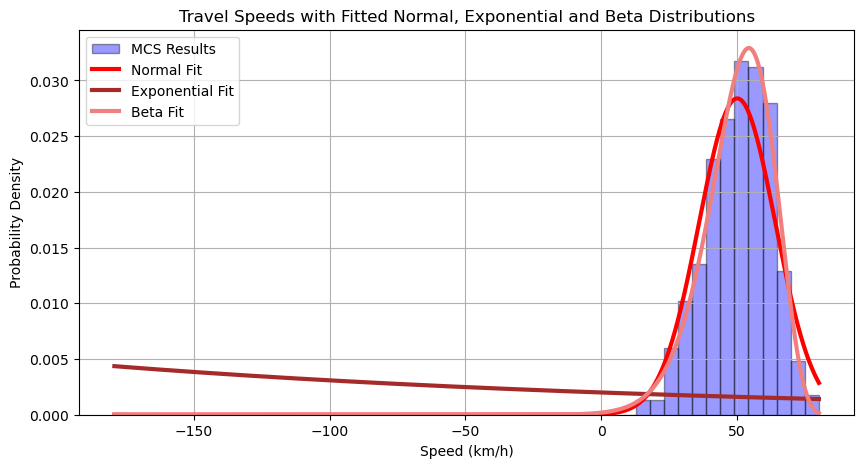

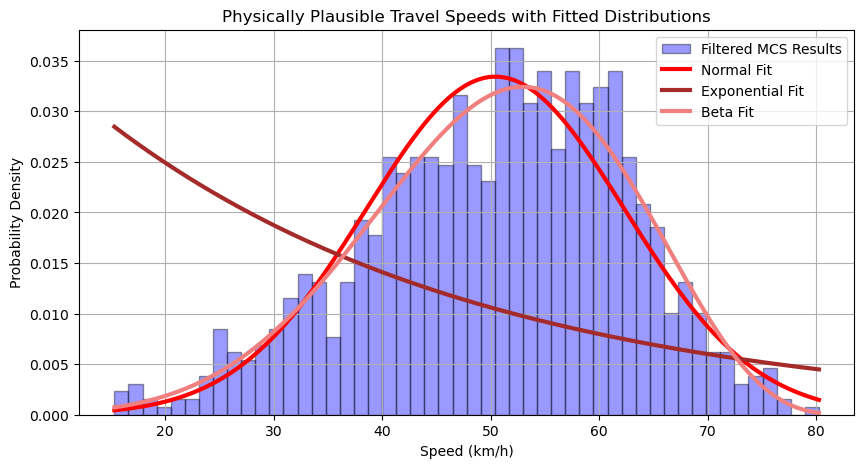

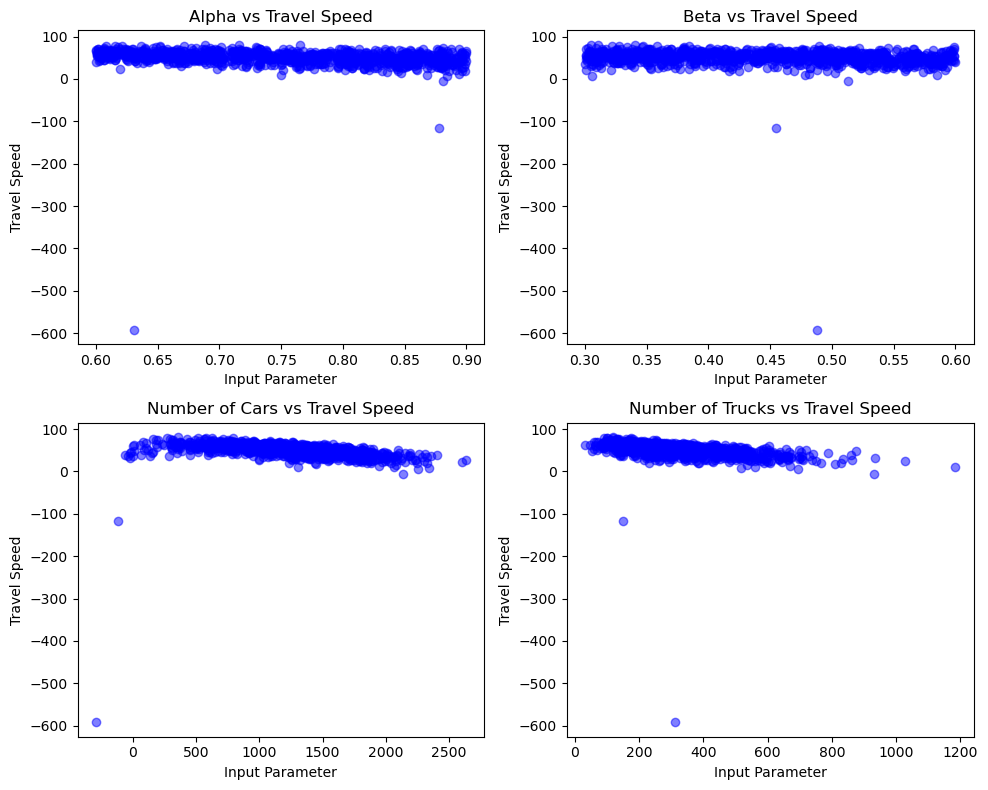

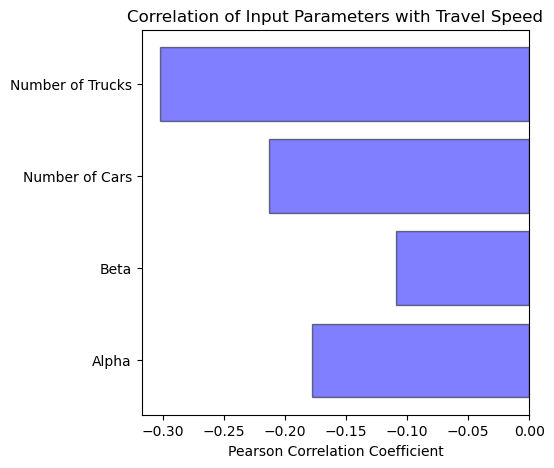

In [2]:
# ============================
# Distribution fitting
# ============================

# Maximum Likelihood Estimation (MLE) is a parameter estimation technique used to fit
# a chosen probability distribution to observed data by maximising the likelihood function.
# The probability density function (PDF) f(x | θ) describes the likelihood of observing a
# data point x given a specific set of parameters θ.
# The likelihood function L(θ | x₁, …, xₙ) reverses this perspective: it measures how plausible
# different parameter values θ are, given the observed dataset.
# In practice, the contributions from all data points are combined multiplicatively,
# and the logarithm of the likelihood (log-likelihood) is maximised for numerical stability.
# The optimal parameters are obtained by solving the argmax of the log-likelihood function.

# The following Monte Carlo simulation (MCS) is adapted from Week 5.
# The average travel speed on a two-lane highway is modelled as a function of traffic
# composition, specifically the number of cars and trucks.
#
# The travel speed V (km/h) is estimated using:
# V = Vf (1 − α (Nc + Nt) / C − β Pt)
#
# where:
# Vf = free-flow speed (100 km/h)
# C  = road capacity (3000 vehicles/hour)
# α  = congestion sensitivity coefficient ~ Uniform[0.6, 0.9]
# β  = truck impact factor ~ Uniform[0.3, 0.6]
# Nc = number of cars per hour ~ Normal(1200, 486²)
# Nt = number of trucks per hour ~ Beta(4, 50) scaled by 4500
# Pt = proportion of trucks in the traffic stream

# ============================
# Library imports
# ============================

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# ============================
# Travel speed model
# ============================

# Defines the travel speed model as a function of traffic composition and model parameters
def travel_speed(alpha, beta, num_c, num_t, free_f=100, cap=3000):
    v_tot = num_c + num_t
    average_speed = free_f * (1 - alpha * (v_tot / cap) - beta * (num_t / v_tot))
    return average_speed

# ============================
# Monte Carlo simulation
# ============================

# Preallocate an array to store the simulated travel speeds
results = np.zeros(1000)

# Generate 1000 Monte Carlo samples of the travel speed
for i in range(1000):
    alpha_rand = 0.6 + np.random.rand() * 0.3
    # A new variable is required because alpha inside the function definition is a placeholder
    beta_rand = 0.3 + np.random.rand() * 0.3
    c_rand = np.random.normal(1200, 486)
    t_rand = np.random.beta(4, 50) * 4500
    # Evaluate the travel speed model for the sampled parameters
    results[i] = travel_speed(alpha_rand, beta_rand, c_rand, t_rand)

# ============================
# Distribution shape analysis
# ============================

from scipy.stats import skew
# Computes the sample skewness to assess distribution asymmetry
# Values within approximately [-0.5, 0.5] indicate weak skewness
skewness = skew(results)
print("The skewness for the MCS travel speed dataset is", round(skewness, 3))

# ============================
# Histogram and initial fitting
# ============================

# Plot the empirical distribution of the Monte Carlo results
plt.figure(figsize=(10, 5))
plt.hist(results, bins=50, density=True, alpha=0.4,
         edgecolor='black', color='blue', label='MCS Results')
plt.title("Travel Speeds with Fitted Normal, Exponential and Beta Distributions")
plt.xlabel("Speed (km/h)")
plt.ylabel("Probability Density")
plt.grid(True)

# Perform MLE-based parameter estimation for candidate distributions
norm_params = stats.norm.fit(results)
expo_params = stats.expon.fit(results)
beta_params = stats.beta.fit(results)

# Display the fitted parameters for each distribution
print("Parameters for normal distribution:", tuple(np.round(norm_params, 3)))
# Equivalent to estimating the sample mean and standard deviation
print("Parameters for exponential distribution:", tuple(np.round(expo_params, 3)))
print("Parameters for beta distribution:", tuple(np.round(beta_params, 3)))

# ============================
# PDF generation and overlay
# ============================

# Generate a common x-axis for evaluating fitted PDFs
x = np.linspace(results.min(), results.max(), 1000)

# Evaluate the fitted probability density functions
y_norm = stats.norm.pdf(x, *norm_params)
y_expo = stats.expon.pdf(x, *expo_params)
y_beta = stats.beta.pdf(x, *beta_params)

# Overlay the fitted PDFs on the histogram
plt.plot(x, y_norm, color='red', linewidth=3, label='Normal Fit')
plt.plot(x, y_expo, color='brown', linewidth=3, label='Exponential Fit')
plt.plot(x, y_beta, color='lightcoral', linewidth=3, label='Beta Fit')
plt.legend()

# ============================
# Physical filtering of results
# ============================

# Remove non-physical values: travel speed must lie within (0, Vf]
V_min = 0
V_max = 100
valid_mask = (results > V_min) & (results <= V_max)
results_masked = results[valid_mask]

print("Original sample size:", len(results))
print("Filtered sample size:", len(results_masked))

# ============================
# Refit distributions to filtered data
# ============================

norm_params_mask = stats.norm.fit(results_masked)
expo_params_mask = stats.expon.fit(results_masked)
beta_params_mask = stats.beta.fit(results_masked)

x_mask = np.linspace(results_masked.min(), results_masked.max(), 1000)
y_norm_mask = stats.norm.pdf(x_mask, *norm_params_mask)
y_expo_mask = stats.expon.pdf(x_mask, *expo_params_mask)
y_beta_mask = stats.beta.pdf(x_mask, *beta_params_mask)

print("New parameters for normal distribution:", tuple(np.round(norm_params_mask, 3)))
print("New parameters for exponential distribution:", tuple(np.round(expo_params_mask, 3)))
print("New parameters for beta distribution:", tuple(np.round(beta_params_mask, 3)))

# Plot filtered results with updated fitted distributions
plt.figure(figsize=(10, 5))
plt.hist(results_masked, bins=50, density=True, alpha=0.4,
         color='blue', edgecolor='black', label="Filtered MCS Results")
plt.title("Physically Plausible Travel Speeds with Fitted Distributions")
plt.xlabel("Speed (km/h)")
plt.ylabel("Probability Density")
plt.grid(True)
plt.plot(x_mask, y_norm_mask, color='red', linewidth=3, label='Normal Fit')
plt.plot(x_mask, y_expo_mask, color='brown', linewidth=3, label='Exponential Fit')
plt.plot(x_mask, y_beta_mask, color='lightcoral', linewidth=3, label='Beta Fit')
plt.legend()

# ============================
# Kolmogorov–Smirnov goodness-of-fit testing
# ============================

# Convert to NumPy array to ensure compatibility with scipy.stats.kstest
results_masked = np.asarray(results_masked)

# Perform K–S tests against the fitted distributions
D_norm, p_value_norm = stats.kstest(results_masked, 'norm', args=norm_params_mask)
D_expo, p_value_expo = stats.kstest(results_masked, 'expon', args=expo_params_mask)
D_beta, p_value_beta = stats.kstest(results_masked, 'beta', args=beta_params_mask)

print("K-S statistic for normal distribution:", round(D_norm, 3))
print("p-value for normal distribution:", round(p_value_norm, 3))
print("K-S statistic for exponential distribution:", round(D_expo, 3))
print("p-value for exponential distribution:", round(p_value_expo, 3))
print("K-S statistic for beta distribution:", round(D_beta, 3))
print("p-value for beta distribution:", round(p_value_beta, 3))

# Hypothesis testing at the 5% significance level
alpha = 0.05

if p_value_norm < alpha:
    decision = "reject the null hypothesis"
else:
    decision = "do not reject the null hypothesis"
print("With respect to the normal distribution,", decision)

if p_value_expo < alpha:
    decision = "reject the null hypothesis"
else:
    decision = "do not reject the null hypothesis"
print("With respect to the exponential distribution,", decision)

if p_value_beta < alpha:
    decision = "reject the null hypothesis"
else:
    decision = "do not reject the null hypothesis"
print("With respect to the beta distribution,", decision)

# Identify the most statistically consistent distribution based on p-value
if p_value_norm > p_value_beta:
    print("The normal distribution is the most consistent fit to the dataset.")
else:
    print("The beta distribution is the most consistent fit to the dataset.")

# ============================
# Sensitivity analysis
# ============================

# Generate independent samples of each input parameter
alpha_rand_sens = 0.6 + 0.3 * np.random.rand(1000)
beta_rand_sens = 0.3 + 0.3 * np.random.rand(1000)
c_rand_sens = np.random.normal(1200, 486, size=1000)
t_rand_sens = np.random.beta(4, 50, size=1000) * 4500

# Evaluate the travel speed model for sensitivity analysis
results_sens = travel_speed(alpha_rand_sens, beta_rand_sens,
                            c_rand_sens, t_rand_sens)

# Compute the Pearson product-moment correlation coefficient (PMCC) matrix
pmcc_matrix = np.corrcoef([alpha_rand_sens, beta_rand_sens,
                           c_rand_sens, t_rand_sens, results_sens])
print(pmcc_matrix)

# ============================
# Scatter plots for sensitivity
# ============================

# Create a 2×2 grid of scatter plots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax[0, 0].scatter(alpha_rand_sens, results_sens, alpha=0.5, color='blue')
ax[0, 1].scatter(beta_rand_sens, results_sens, alpha=0.5, color='blue')
ax[1, 0].scatter(c_rand_sens, results_sens, alpha=0.5, color='blue')
ax[1, 1].scatter(t_rand_sens, results_sens, alpha=0.5, color='blue')

ax[0, 0].set_title("Alpha vs Travel Speed")
ax[0, 1].set_title("Beta vs Travel Speed")
ax[1, 0].set_title("Number of Cars vs Travel Speed")
ax[1, 1].set_title("Number of Trucks vs Travel Speed")

for axes in ax.flatten():
    axes.set_xlabel("Input Parameter")
    axes.set_ylabel("Travel Speed")

plt.tight_layout()

# ============================
# Correlation bar chart
# ============================

# Visualise the PMCC values using a horizontal bar chart
labels = ['Alpha', 'Beta', 'Number of Cars', 'Number of Trucks']
plt.figure(figsize=(5, 5))
plt.barh(labels, pmcc_matrix[-1, :-1],
         color='blue', alpha=0.5, edgecolor='black')
plt.title('Correlation of Input Parameters with Travel Speed')
plt.xlabel("Pearson Correlation Coefficient")

plt.show()